# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2 as cv
from glob import glob
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [4]:
DIR = '../input/ocular-disease-recognition-odir5k'

full_df = pd.read_csv(f'{DIR}/full_df.csv', index_col=0)

full_df.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
ID,,,,,,,,,,,,,,,,,,
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Data Preprocessing

In [5]:
full_df['side'] = full_df['filename'].str[:-4].str.replace(r'\d+_', '', regex=True)

In [6]:
image_dir = '../input/ocular-disease-recognition-odir5k/ODIR-5K/'
full_df['filepath'] = full_df['filepath'].str.replace(image_dir, image_dir + 'ODIR-5K/')

In [7]:
age_intervals = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81+']
full_df['Age Group'] = pd.cut(full_df['Patient Age'], bins=age_intervals, labels=age_labels, right=False)

In [8]:
full_df['labels_text'] = full_df['labels'].apply(lambda x: x[2])
full_df['target'] = np.where(full_df['labels_text'] == "A", 1, 0)

In [9]:
print("AMD positive:", len(full_df[full_df['target']==1]))
print("AMD negative:", len(full_df[full_df['target']==0]))

AMD positive: 266
AMD negative: 6126


# Split Dataset

In [10]:
right_df = full_df[full_df['side'] == 'right']
left_df = full_df[full_df['side'] == 'left']

# Fix data imbalance

right_df_0 = right_df[right_df['target'] == 0]
right_df_0 = right_df_0.sample(frac=0.25, random_state=42)
right_df_1 = right_df[right_df['target'] == 1]

left_df_0 = left_df[left_df['target'] == 0]
left_df_0 = left_df_0.sample(frac=0.25, random_state=42)
left_df_1 = left_df[left_df['target'] == 1]

right_df = pd.concat([right_df_0, right_df_1])
left_df = pd.concat([left_df_0, left_df_1])

right_df = right_df.sample(frac=1, random_state=42)
left_df = left_df.sample(frac=1, random_state=42)

right_train, right_test = train_test_split(right_df, test_size=0.2, random_state=42)
left_train, left_test = train_test_split(left_df, test_size=0.2, random_state=42)

train_df = pd.concat([right_train, left_train])
valid_df = pd.concat([right_test, left_test])

# Prepare Dataset and Dataloader

In [11]:
class EyeDataset(Dataset):
    def __init__(self, df, data_transform = None):
        self.df = df
        self.data_transform = data_transform
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406),
                       (0.229, 0.224, 0.225))
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filepath = self.df.iloc[idx]['filepath']
        image = cv.imread(filepath)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, thresholded = cv.threshold(image, 0, 255, cv.THRESH_OTSU)
        x, y, w, h = cv.boundingRect(thresholded)
        cropped_image = cv.cvtColor(image[y:y+h, x:x+w], cv.COLOR_GRAY2RGB)
        cropped_image = Image.fromarray(cropped_image)
        target = self.df.iloc[idx]['target']
        
        return cropped_image, target
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        targets = targets.to(device)
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        ).to(device)
        return imgs, targets

In [12]:
data_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomResizedCrop(224, scale=(0.8, 1.0))
])

In [13]:
train_ds = EyeDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)

valid_ds = EyeDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=32,
                      collate_fn=valid_ds.collate_fn)

In [14]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))

Size of Train: 1436
Size of Validation: 361


# Model

In [15]:
class EyeClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
            
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
classifier = EyeClassifier(pretrained=True)
_ = summary(classifier, torch.ones(1,3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.3MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 28, 28] 

# Define Train and Validate Functions

In [17]:
def crop_image(image):
    _, thresholded = cv.threshold(image, 0, 255, cv.THRESH_OTSU)
    x, y, w, h = cv.boundingRect(thresholded)
    return image[y:y+h, x:x+w]

In [18]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    
    fake_recall_score = recall_score(targets, preds, pos_label=0,zero_division=0)
    fake_accuracy_score = accuracy_score(targets, preds)
    fake_precision_score = precision_score(targets, preds, pos_label=0,zero_division=0)
    fake_f1_score = f1_score(targets, preds, pos_label=0,zero_division=0)
    fpr, tpr, thresholds = roc_curve(targets, outputs)
    roc_auc = auc(fpr, tpr)
    
    return loss.cpu().detach().item(), fake_recall_score, fake_accuracy_score, fake_precision_score, fake_f1_score, fpr, tpr, roc_auc

In [19]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, pos_label=0, zero_division=0)
    fake_accuracy_score = accuracy_score(targets, preds)
    fake_precision_score = precision_score(targets, preds, pos_label=0,zero_division=0)
    fake_f1_score = f1_score(targets, preds, pos_label=0,zero_division=0)
    fpr, tpr, thresholds = roc_curve(targets, outputs)
    roc_auc = auc(fpr, tpr)
    
    return loss.cpu().detach().item(), fake_recall_score, fake_accuracy_score, fake_precision_score, fake_f1_score, fpr, tpr, roc_auc

# Training Model

In [20]:
classifier = EyeClassifier(pretrained=True).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                      gamma=0.25)
best_recall_score = 0
n_epochs = 10
xticks = list(i+1 for i in range(n_epochs))

In [21]:
mem = {
    'train_loss': [],
    'train_recall_score': [],
    'train_accuracy_score': [],
    'train_precision_score': [],
    'train_f1_score': [],
    'train_tpr': [],
    'train_fpr': [],
    'train_auc': [],
    'valid_loss': [],
    'valid_recall_score': [],
    'valid_accuracy_score': [],
    'valid_precision_score': [],
    'valid_f1_score': [],
    'valid_tpr': [],
    'valid_fpr': [],
    'valid_auc': [],
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recall_scores, train_accuracy_scores, train_precision_scores, train_f1_scores, train_tprs, train_fprs, train_aucs = [], [], [], [], [], [], [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall_score, train_accuracy_score, train_precision_score, train_f1_score, train_tpr, train_fpr, train_auc = train(data, classifier, optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recall_scores.append(train_recall_score)
        train_accuracy_scores.append(train_accuracy_score)
        train_precision_scores.append(train_precision_score)
        train_f1_scores.append(train_f1_score)
        train_tprs.append(train_tpr)
        train_fprs.append(train_fpr)
        if not np.isnan(train_auc):
            train_aucs.append(train_auc)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall score:', "%.3f" % train_recall_score, 
            '\ttrain accuracy score:', "%.3f" % train_accuracy_score, 
            '\ttrain precision score:', "%.3f" % train_precision_score, 
            '\ttrain f1 score:', "%.3f" % train_f1_score, 
            '\ttrain auc:', "%.3f" % train_auc, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall_score'].append(np.mean(train_recall_scores))
    mem['train_accuracy_score'].append(np.mean(train_accuracy_scores))
    mem['train_precision_score'].append(np.mean(train_precision_scores))
    mem['train_f1_score'].append(np.mean(train_f1_scores))
    mem['train_tpr'].append(np.concatenate(train_fprs))
    mem['train_fpr'].append(np.concatenate(train_tprs))
    mem['train_auc'].append(np.mean(train_aucs))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recall_scores, valid_f1_scores, valid_accuracy_scores, valid_precision_scores, valid_tprs, valid_fprs, valid_aucs =  [], [], [], [], [], [], [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall_score, valid_accuracy_score, valid_precision_score, valid_f1_score, valid_tpr, valid_fpr, valid_auc = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recall_scores.append(valid_recall_score)
        valid_accuracy_scores.append(valid_accuracy_score)
        valid_precision_scores.append(valid_precision_score)
        valid_f1_scores.append(valid_f1_score)
        valid_tprs.append(valid_tpr)
        valid_fprs.append(valid_fpr)
        valid_aucs.append(valid_auc)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall score:', "%.3f" % valid_recall_score, 
            '\tvalid accuracy score:', "%.3f" % valid_accuracy_score, 
            '\tvalid precision score:', "%.3f" % valid_precision_score, 
            '\tvalid f1 score:', "%.3f" % valid_f1_score, 
            '\tvalid auc:', "%.3f" % valid_auc, 
            end='\r'
        )
    
    cur_recall_score = np.mean(valid_recall_scores)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall_score'].append(np.mean(valid_recall_scores))
    mem['valid_accuracy_score'].append(np.mean(valid_accuracy_scores))
    mem['valid_precision_score'].append(np.mean(valid_precision_scores))
    mem['valid_f1_score'].append(np.mean(valid_f1_scores))
    mem['valid_tpr'].append(np.concatenate(valid_fprs))
    mem['valid_fpr'].append(np.concatenate(valid_tprs))
    mem['valid_auc'].append(np.mean(valid_aucs))
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall score:', "%.3f" % mem['train_recall_score'][-1],
        '\ttrain accuracy score:', "%.3f" % mem['train_accuracy_score'][-1],
        '\ttrain precision score:', "%.3f" % mem['train_precision_score'][-1],
        '\ttrain f1 score:', "%.3f" % mem['train_f1_score'][-1],
        '\ttrain auc:', "%.3f" % mem['train_auc'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall score:', "%.3f" % mem['valid_recall_score'][-1],
        '\tvalid accuracy score:', "%.3f" % mem['valid_accuracy_score'][-1],
        '\tvalid precision score:', "%.3f" % mem['valid_precision_score'][-1],
        '\tvalid f1 score:', "%.3f" % mem['valid_f1_score'][-1],
        '\tvalid auc:', "%.3f" % mem['valid_auc'][-1],
    )
    
    if epoch > 5 and best_recall_score < cur_recall_score:
        best_recall_score = cur_recall_score
        torch.save(classifier.state_dict(), './saved_model/amd_state_dict.pth')
        torch.save(classifier, './saved_model/amd_model.pth')
        
    scheduler.step()

Training:   0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.701 	train recall score: 0.597 	train accuracy score: 0.604 	train precision score: 0.906 	train f1 score: 0.715 	train auc: 0.686 	valid loss: 0.454 	valid recall score: 0.891 	valid accuracy score: 0.840 	valid precision score: 0.920 	valid f1 score: 0.903 	valid auc: 0.784
epoch: 2 	train loss: 0.470 	train recall score: 0.828 	train accuracy score: 0.829 	train precision score: 0.968 	train f1 score: 0.889 	train auc: 0.909 	valid loss: 0.747 	valid recall score: 0.866 	valid accuracy score: 0.838 	valid precision score: 0.938 	valid f1 score: 0.900 	valid auc: 0.810


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


epoch: 3 	train loss: 0.341 	train recall score: 0.921 	train accuracy score: 0.903 	train precision score: 0.968 	train f1 score: 0.941 	train auc: 0.954 	valid loss: 1.788 	valid recall score: 0.774 	valid accuracy score: 0.764 	valid precision score: 0.941 	valid f1 score: 0.845 	valid auc: 0.809
epoch: 4 	train loss: 0.191 	train recall score: 0.974 	train accuracy score: 0.960 	train precision score: 0.982 	train f1 score: 0.976 	train auc: 0.989 	valid loss: 0.615 	valid recall score: 0.964 	valid accuracy score: 0.894 	valid precision score: 0.917 	valid f1 score: 0.939 	valid auc: 0.821


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


epoch: 5 	train loss: 0.154 	train recall score: 0.975 	train accuracy score: 0.967 	train precision score: 0.989 	train f1 score: 0.979 	train auc: 0.999 	valid loss: 0.639 	valid recall score: 0.937 	valid accuracy score: 0.888 	valid precision score: 0.932 	valid f1 score: 0.933 	valid auc: 0.837
epoch: 6 	train loss: 0.097 	train recall score: 0.993 	train accuracy score: 0.987 	train precision score: 0.991 	train f1 score: 0.992 	train auc: 0.999 	valid loss: 0.587 	valid recall score: 0.952 	valid accuracy score: 0.888 	valid precision score: 0.918 	valid f1 score: 0.934 	valid auc: 0.830
epoch: 7 	train loss: 0.083 	train recall score: 0.991 	train accuracy score: 0.989 	train precision score: 0.997 	train f1 score: 0.993 	train auc: 1.000 	valid loss: 0.570 	valid recall score: 0.970 	valid accuracy score: 0.886 	valid precision score: 0.903 	valid f1 score: 0.935 	valid auc: 0.830
epoch: 8 	train loss: 0.068 	train recall score: 0.997 	train accuracy score: 0.994 	train precis

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


epoch: 9 	train loss: 0.104 	train recall score: 0.984 	train accuracy score: 0.981 	train precision score: 0.996 	train f1 score: 0.989 	train auc: 1.000 	valid loss: 0.608 	valid recall score: 0.946 	valid accuracy score: 0.893 	valid precision score: 0.929 	valid f1 score: 0.937 	valid auc: 0.841
epoch: 10 	train loss: 0.098 	train recall score: 0.976 	train accuracy score: 0.974 	train precision score: 0.996 	train f1 score: 0.985 	train auc: 0.999 	valid loss: 0.585 	valid recall score: 0.982 	valid accuracy score: 0.898 	valid precision score: 0.908 	valid f1 score: 0.942 	valid auc: 0.842


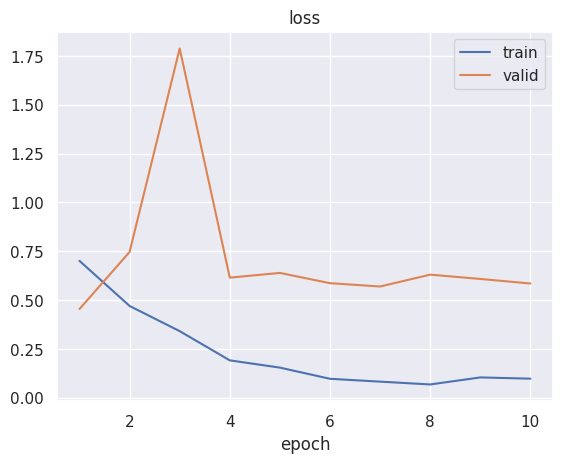

In [22]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

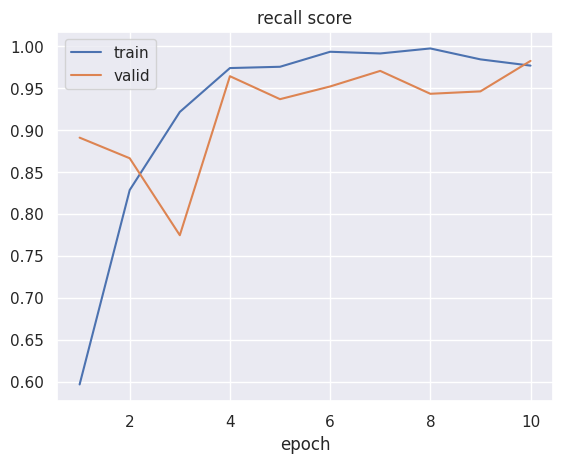

In [23]:
plt.plot(xticks, mem['train_recall_score'])
plt.plot(xticks, mem['valid_recall_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()

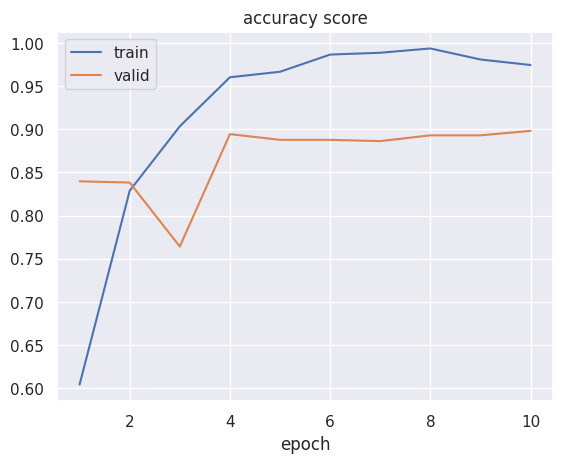

In [24]:
plt.plot(xticks, mem['train_accuracy_score'])
plt.plot(xticks, mem['valid_accuracy_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('accuracy score')
plt.show()

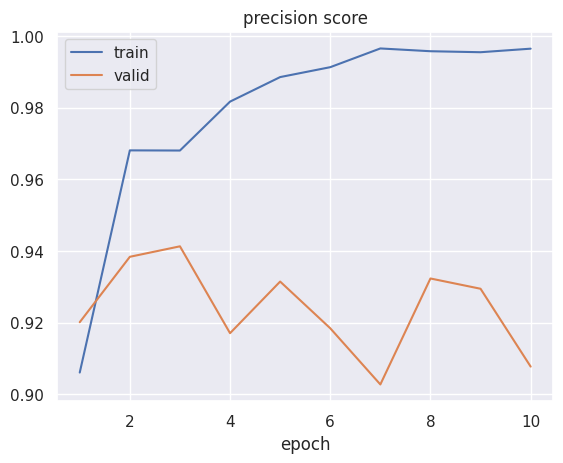

In [25]:
plt.plot(xticks, mem['train_precision_score'])
plt.plot(xticks, mem['valid_precision_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('precision score')
plt.show()

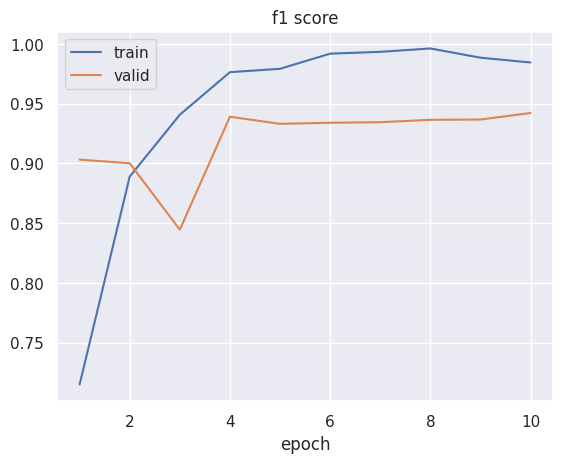

In [26]:
plt.plot(xticks, mem['train_f1_score'])
plt.plot(xticks, mem['valid_f1_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('f1 score')
plt.show()

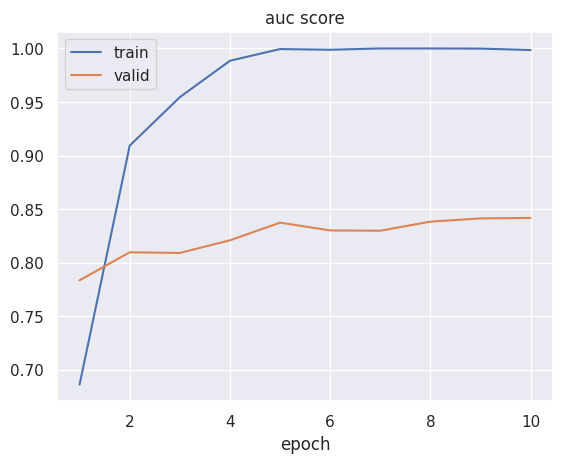

In [27]:
plt.plot(xticks, mem['train_auc'])
plt.plot(xticks, mem['valid_auc'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('auc score')
plt.show()